# BAYESIAN OPTIMIZATION - CODING

![BO](BO.jpg)

## PSEUDO CODE

This script aims to realize Bayesian Optimization using sequential Gaussian Process (GP) as surrogate model. The algorithm is based on the following steps:

1. **Initialization**: Select a set of initial points to evaluate the objective function.
2. **Model Fitting**: Fit a GP model to the data.
3. **Acquisition Function**: Define an acquisition function to determine the next point to evaluate.
4. **Optimization**: Find the next point that maximizes the acquisition function.
5. **Update**: Evaluate the objective function at the selected point and add it to the dataset.
6. **Repeat**: Repeat steps 2-5 until the stopping criterion is met.

![BO](BAYESIAN-OPTIMIZATION.png)

## INGREDIENTS

0: THE SEARCH SPACE $X$ - ${[lb_1,ub_1],...,[lb_m,ub_m]}$

1: THE OBJECTIVE FUNCTION $f(x)$ - the black box

2: THE DATASET $D$ - $\{(x_1, y_1), (x_2, y_2), ..., (x_t, y_t)\}$

3: THE SURROGATE MODEL $M(x)$ - Gaussian Process

4: THE ACQUISITION FUNCTION $S(x)$ - Expected Improvement (EI)

5: THE OPTIMIZATION ALGORITHM - L-BFGS-B

6: THE STOPPING CRITERION - Maximum number of iterations / Tolerance

## REALIZATION

### Helpers

In [1]:
# DEPENDENCIES
import numpy as np
import matplotlib.pyplot as plt

In [223]:
# CONFIGURABLE PARAMETERS

## Hyperparameters
noise_lvl = 0.1
k_alpha = 1
k_lambda = 1

## Process Control
num_init_points = 10
num_iter = 50
tolerance = 1e-3
gap = np.inf

## Acquisition Function - UCB
beta = 2

In [144]:
## Search Space
### parameter 1 - a
lb_a = -600
ub_a = 400
c_a = (ub_a + lb_a) / 2
print(c_a)

### parameter 2 - b
lb_b = -400
ub_b = 600
c_b = (ub_b + lb_b) / 2
print(c_b)

-100.0
100.0


In [230]:
# THE OBJECTIVE FUNCTION - this is actually the black box, here I use a simple example to represent the black box
def objective_function(a, b):
    # ret = -1*(a-c_a)**2 - 1*(b-c_b)**2 + 25
    ret = np.sin(0.05*a*np.pi) + 5 * np.sin(a*np.pi*0.01/5) + 0.2*np.cos(0.01 * b)
    # noise term
    noise = np.random.normal(0, noise_lvl)
    ret += noise
    return ret

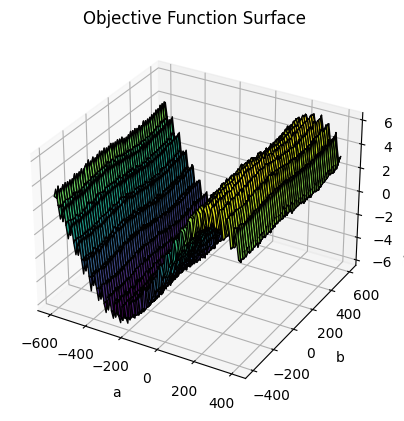

In [232]:
from mpl_toolkits.mplot3d import Axes3D

# 生成 a 和 b 的网格
a_vals = np.linspace(lb_a, ub_a, 100)  # a 的范围
b_vals = np.linspace(lb_b, ub_b, 100)  # b 的范围
A, B = np.meshgrid(a_vals, b_vals)  # 生成网格

# 计算目标函数值
Z = np.vectorize(objective_function)(A, B)

# 创建 3D 绘图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
ax.plot_surface(A, B, Z, cmap='viridis', edgecolor='k')

# 设置标签
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Objective Function Value')

# 显示图形
plt.title('Objective Function Surface')
plt.show()

In [269]:
# THE SURROGATE MODEL - Gaussian Process - Kernel Function
## Matern 2.5 as the kernel function
def kernel(p1, p2, matern_alpha = 1, matern_lambda = 1):
    # define the distance between two points p1 and p2
    # d = np.linalg.norm(p1 - p2)
    d = (((p1[0] - p2[0])/20.0)**2 + ((p1[1] - p2[1]))**2) ** 0.5
    k = matern_alpha * (1 + np.sqrt(5) * d / matern_lambda + 5 * d**2 / (3 * matern_lambda**2)) * np.exp(-np.sqrt(5) * d / matern_lambda)
    return k

## Mean and Variance of the Gaussian Process
def mean_var(x, D, K_alpha, k_lambda):
    # assume x is a variable of 1x1
    # calculate the mean and variance of the Gaussian Process
    x_dim = x.shape[1] # assume each colum is a dimension of x
    num_D = D.shape[0] # number of data points in D
    
    Ktt = np.zeros((num_D, num_D))
    for i in range(num_D):
        for j in range(num_D):
            Ktt[i, j] = kernel(D[i,:-1], D[j,:-1], K_alpha, k_lambda)
    Kttn = Ktt + np.eye(num_D) * noise_lvl
    IKttn = np.linalg.inv(Kttn)
    
    Kpt = np.zeros((1, num_D))
    for i in range(num_D):
        Kpt[0, i] = kernel(x[0], D[i,:-1], K_alpha, k_lambda)
    Ktp = Kpt.T
    Kpp = kernel(x[0], x[0], K_alpha, k_lambda)
    
    y = D[:,-1].reshape(-1,1)
    
    mean = Kpt @ IKttn @ y
    var = Kpp - Kpt @ IKttn @ Ktp
        
    return mean, var

In [ ]:
## Hyperparameters
# used in weighted UCB
w0 = 0.0
w1 = 1.0

## Direction variance of the Gaussian Process
def var_i(x, D, K_alpha, k_lambda):
    # assume x is a variable of 1x1
    # calculate the mean and variance of the Gaussian Process
    x_dim = x.shape[1] # assume each colum is a dimension of x
    num_D = D.shape[0] # number of data points in D
    
    var_list = np.zeros(2, dtype=float)
    for d in range(2):
        Ktt = np.zeros((num_D, num_D))
        for i in range(num_D):
            for j in range(num_D):
                Ktt[i, j] = kernel(D[i,d], D[j,d], K_alpha, k_lambda)
        Kttn = Ktt + np.eye(num_D) * noise_lvl
        IKttn = np.linalg.inv(Kttn)
        
        Kpt = np.zeros((1, num_D))
        for i in range(num_D):
            Kpt[0, i] = kernel(x[0][d], D[i,d], K_alpha, k_lambda)
        Ktp = Kpt.T
        Kpp = kernel(x[0][d], x[0][d], K_alpha, k_lambda)

        var = Kpp - Kpt @ IKttn @ Ktp
        var_list[d] = var
     
    return var_list

In [235]:
# THE ACQUISITION FUNCTION - UPPER CONFIDENCE BOUND(UCB)
def S(x, D):
    mean, var = mean_var(x, D, k_alpha, k_lambda)
    s = mean + beta * np.sqrt(var)
    # var_list = var_i(x, D, k_alpha, k_lambda)
    # s = mean + beta * (np.sqrt(var) + w0 * np.sqrt(var_list[0]) + w1 * np.sqrt(var_list[1]))
    return s

In [236]:
# THE OPTIMIZATION FUNCTION FOR THE ACQUISITION FUNCTION
def optimize_acquisition(D):
    # randomly search for the point with the highest acquisition function value
    num_search = 100
    max_s = -np.inf
    max_x = None
    cur_x = np.zeros((1,2))
    for i in range(num_search):
        cur_x[0,0] = np.random.uniform(lb_a, ub_a)
        cur_x[0,1] = np.random.uniform(lb_b, ub_b)
        cur_s = S(cur_x, D)
        if cur_s > max_s:
            max_s = cur_s
            max_x = cur_x.copy()
    return max_x

### The Optimization Process

In [237]:
# PHASE 1 - INITIAL DATASET
D = np.zeros((num_init_points, 3)) # first column is a, second column is b, third column is the objective function value
for i in range(num_init_points):
    a = np.random.uniform(lb_a, ub_a)
    b = np.random.uniform(lb_b, ub_b)
    D[i, 0] = a
    D[i, 1] = b
    D[i, 2] = objective_function(a, b)

D1 = D

In [276]:
D = D1

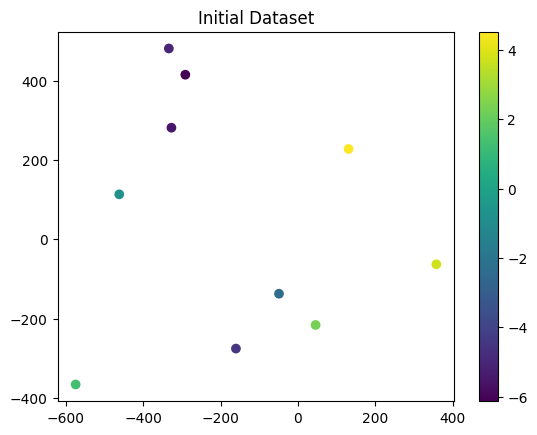

In [277]:
# plot the initial dataset
plt.figure()
plt.scatter(D[:,0], D[:,1], c=D[:,2], cmap='viridis')
plt.colorbar()
plt.title('Initial Dataset')
plt.show()

In [278]:
# PHASE 2 - OPTIMIZATION ITERATIONS
for i in range(num_iter):
    
    # (1) use the surrogate model to approach the posterior distribution of the objective function, modeled by Gaussian Process which can be characterized by the mean function and the covariance function
    
    ## mean, var = mean_var(x, D, 1, 1)
    
    # (2) determine the next point to evaluate using the acquisition function S(D)
    x_eval = optimize_acquisition(D)
    
    # (3) evaluate the objective function at the next point
    f_eval = objective_function(x_eval[0,0], x_eval[0,1])
    
    # (4) update the dataset D
    newpoint = np.zeros((1,3))
    newpoint[0,0] = x_eval[0,0]
    newpoint[0,1] = x_eval[0,1]
    newpoint[0,2] = f_eval
    D = np.vstack((D, newpoint))
    
    # (5) check the stopping criterion
    gap = np.abs(D[-1, -1] - D[-2, -1])
    if gap < tolerance:
        break
    


In [281]:
# number of points in D
print(D.shape[0])

60


In [279]:
# print the final value
print(D[-1, -1])

# print the max value
print(np.max(D[:, -1]))

# print the argmax
print(D[np.argmax(D[:, -1]), :-1])

4.416090696808681
6.105898852685572
[288.66645658 -60.14272688]


In [282]:
a = 251.89770377
b = -57.19850906
print(objective_function(a, b))
print(D[:, -1])

6.251023199649747
[ 2.29134449 -5.04983451 -0.82373284 -6.1348472  -5.53539194  3.73927841
  4.52326124 -4.43393499  1.32481616 -2.38824487  3.73097501  2.67626962
  4.74363321  1.36530438 -0.27020442  0.85481281  5.42897375  1.2960883
  1.21996595  2.27837051 -3.72762852  1.80801134  3.41164774 -2.67378875
  1.27568584 -0.08779181  0.32517416  1.14923938  3.31310544  1.68563605
  2.25455781  1.79154728  5.45745359  1.91493649  4.68246261  2.40683266
 -1.8173499   3.91839802  3.53823954  4.5504793   2.2252919   1.46165416
  3.68670612  1.26758859  1.10695492  2.01085947 -0.97055819  3.44060638
  1.90856054  2.28418017  4.46827987  5.89632656  3.58927843  3.41647947
  2.75283722  4.26932122  4.81444829 -4.59186022  6.10589885  4.4160907 ]


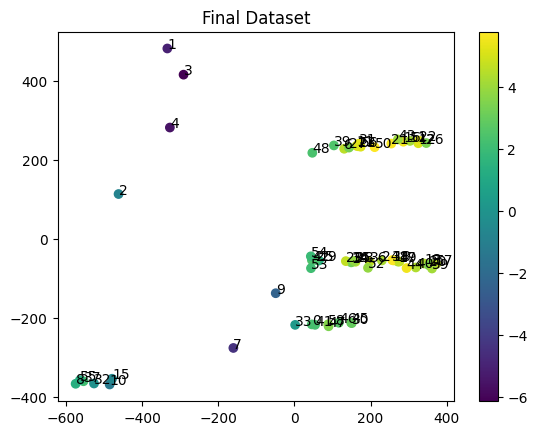

In [275]:
# plot the final dataset and mark the order of the points, mark the max point
plt.figure()
plt.scatter(D[:,0], D[:,1], c=D[:,2], cmap='viridis')
for i in range(D.shape[0]):
    plt.text(D[i,0], D[i,1], str(i))
plt.colorbar()
plt.title('Final Dataset')
plt.show()

